In [3]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from collections import Counter
# from collections import defaultdict
# from sklearn.neighbors import kneighbors_graph
import heapq
df = pd.read_csv(r'hw5_swiss_roll\swiss_roll_hole.txt', header=None,delim_whitespace=True)

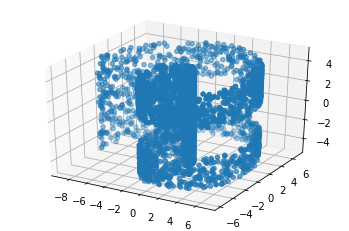

In [4]:
df = df - np.mean(df,axis=0)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(df[0],df[1],df[2])

In [5]:
'''
Adjacency matrix version Dijkstra, not efficient enough, already abandoned
'''
def djk_v2(V, graph, src):
    
    def update(u,v):
        if graph[u,v]>0 and dist[v] > dist[u]+graph[u,v]:
            dist[v] = dist[u]+graph[u,v]
#             prev[v] = u
            heapq.heappush(Q,(dist[v],v))
    
    dist = [np.inf] * V
    dist[src] = 0
#     prev = [None] * V
    
    Q = []
    for i in range(V):
        heapq.heappush(Q,(dist[i],i))
    
    S=[]
    while Q != []:
        u = heapq.heappop(Q)
        
        S.append(u[1])
        
        for v in range(V):
            update(u[1],v)
    return dist, prev


In [6]:
def distance_mat2(X, neib = 10):
    def dist(source,end):
        return scp.linalg.norm((source-end),ord=2)

    X = np.array(X)
    length = len(X)
    temp = np.zeros((length,length))
    for row in range(length):
        for col in range(length):
            temp[row,col] = dist(X[row],X[col])
            
    mat = np.zeros((length,length))
    rank = np.argsort(temp, axis=1)[:,1:neib+1]
    for i in range(length):
        mat[i][rank[i]] = temp[i][rank[i]]
    
    for row in range(length):
        for col in range(length):
            if mat[row,col]==0:
                mat[row,col]=mat[col,row]
    
    return mat 

def adjacency_dict(matrix):
    graph = {}
    for row in range(len(matrix)):
        if row not in graph.keys():
            graph[row]={}
        for col in range(len(matrix)):
            if matrix[row,col]>0:
                graph[row][col] = matrix[row,col]
    return graph


def djk(graph, src):
    '''
    Using dictionary to calculate shortest path is faster than adjacency matrix
    Here our input is a adjacency dictionary of all vertices and min priority heap to optimize the speed
    
    initialize with np.inf to start
    '''
    dist = {vert: np.inf for vert in graph}
    dist[src] = 0

    hq = [(0, src)] #pop out the source vertex
    while len(hq) > 0:
        u_dist, u = heapq.heappop(hq)

        # To avoid repetition, everytime we pop out the minimal distance vertex, we never process it again
        if u_dist > dist[u]:
            continue   
            '''if the current vertex's distance is less than current distance, meaning that there has been
                shortest distance on that vertex and we dont need to update it.
            '''
            
            '''
            For every other vertex that is possible to be place between src and u , we set it to be v
            Then we want to see whether we can update the distance of v from src
            If we successfully update it, we also update the heap
            '''
        for v, v_dist in graph[u].items():
            if dist[v] > u_dist + v_dist:
                dist[v] = u_dist + v_dist
                heapq.heappush(hq,(u_dist + v_dist,v))
    return dist

In [7]:
def ST_path(distance_matrix):
    graph = adjacency_dict(distance_matrix)
    size = len(distance_matrix)
    st_path = np.zeros((size,size))
    for row in range(size):
        dis = djk(graph,row)
        for col in range(size):
            st_path[row,col] = dis[col]
    return st_path

def MDS(matrix):
    Ds = matrix**2
    length = matrix.shape[-1]
    e = np.array([1]*length).reshape((length,1))
    H = np.eye(length) - (1/length)*(e.dot(e.T))
    B = -0.5*((H.dot(Ds)).dot(H))
    
#     meanrows = np.sum(B, axis=0) / matrix.shape[-1]
#     meancols = (np.sum(B, axis=1)/matrix.shape[-1])[:, np.newaxis]
#     meanall = meanrows.sum() /matrix.shape[-1]
#     B -=meanrows
#     B -=meancols
#     B+= meanall
    
    eig_val, eig_vec = np.linalg.eig(B)
    for i in range(length):
        if eig_val[i] < 0:
            eig_val[i] = 0
            
    eig_val = np.diag(eig_val)
    A = eig_vec.dot(scp.linalg.sqrtm(eig_val))
    return A

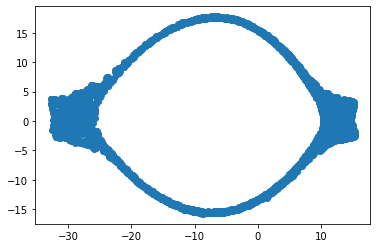

In [9]:
dist_mat = distance_mat2(df)
D = ST_path(dist_mat)
res = MDS(D)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(res[:,0],res[:,1])

In [425]:
def test(df,neib,comp):
    from sklearn.manifold import Isomap
    emb = Isomap(n_neighbors=neib, n_components=comp)
    X_transform = emb.fit_transform(df)
    plt.scatter(X_transform[:,0],X_transform[:,1])

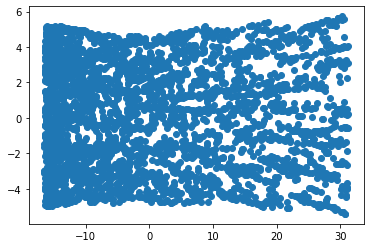

In [426]:
test(df,10,2)

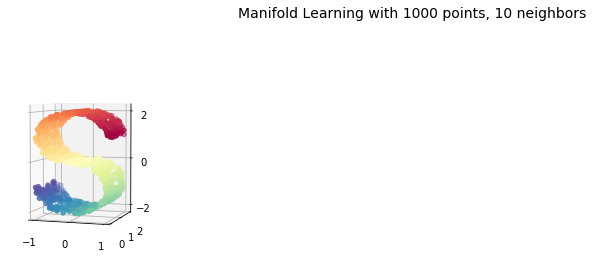

In [388]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

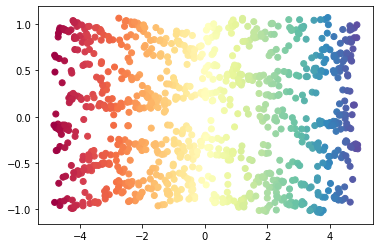

In [396]:
iso = manifold.Isomap(n_neighbors, n_components)
Y = iso.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.show()

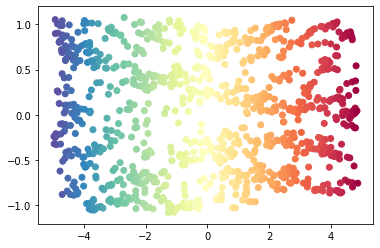

In [402]:
dist_mat = distance_mat2(X)
D = ST_path(dist_mat)
res = MDS(D)
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.scatter(res[:,0],res[:,1])
ax.scatter(res[:, 0], res[:, 1], c=color, cmap=plt.cm.Spectral)

## PCA

In [24]:
def PCA_t(X):
    '''
    X has already been centered
    we directly implement eigendecomposition and find its eigen value and vectors
    then rank those eigen vector and based on eigen values
    '''
    B = (1/len(X))*X.dot(X.T)
    eig_val, eig_vec = np.linalg.eig(B)
    
    '''
    pair each eigen vector with eigen value
    '''
    eig_pairs = [(eig_val[i], eig_vec[:, i]) for i in range(len(eig_val))]
    eig_pairs = sorted(eig_pairs, key=lambda x: x[0], reverse=True) #rank them based on eigen value in reverse order
    eig_pairs = np.array(eig_pairs)
    res = np.hstack([eig_pairs[i, 1].reshape(len(B), 1) for i in range(2)])
    return res
    

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


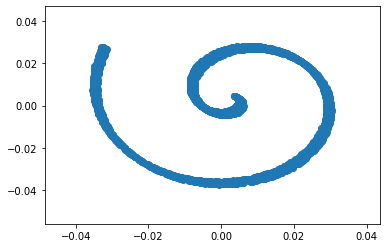

In [25]:
res = PCA_t(df)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(res[:,0],res[:,1])

In [19]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(df)
pca.explained_variance_ratio_

array([0.45874459, 0.29200043])

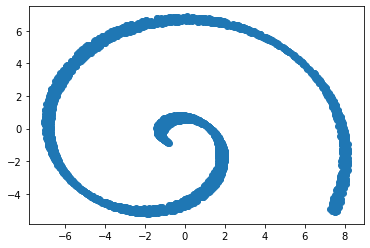

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0],X_r[:,1])

In [17]:
from sklearn import datasets
from sklearn.decomposition import PCA
iris = datasets.load_iris()

In [18]:
X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

In [643]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

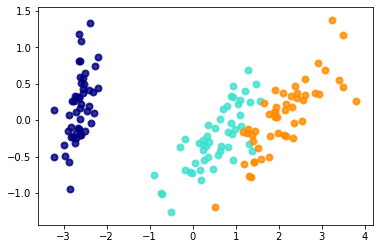

In [600]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

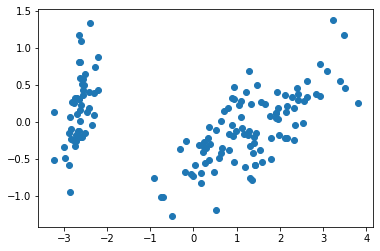

In [602]:
plt.scatter(X_r[:, 0], X_r[:, 1])

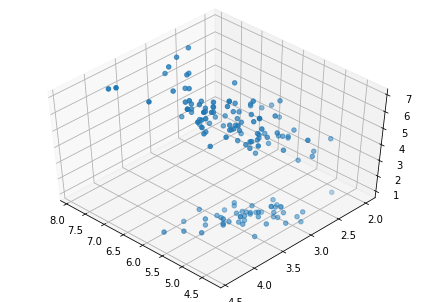

In [653]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[:,0],X[:,1],X[:,2])

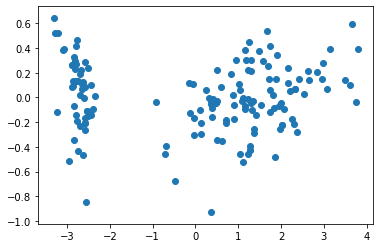

In [658]:
dist_mat = distance_mat2(X[:,:3], neib=50)
D = ST_path(dist_mat)
res = MDS(D)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(res[:,0],res[:,1])